# Import Libraries

In [1]:
#Machine Learning Libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
import nltk
from nltk import word_tokenize, WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

import os
import collections

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
#Deep Learning Libraries

#For Word2Vec Embedding
from gensim import models 
import gensim
from gensim.models import Word2Vec

#For Building Model 
import tensorflow as tf 
import keras 
from keras import regularizers, backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Embedding, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model

In [3]:
!pip install mlxtend

In [4]:
from mlxtend.plotting import plot_confusion_matrix

# Load Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#Load Dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ARTEFAK SIDANG/dataset/fixed_tweets.csv')
data

,tweets,sentiment,label
0,many american lack critical think skill stop l...,negative,-1
1,corona virus germany problem vaccination campaign,negative,-1
2,get vaxxed already covid want beg jab icu damn...,negative,-1
3,shame pro vaxxers judgemental behavior anti va...,negative,-1
4,someone die vaccine,negative,-1
...,...,...,...
3745,vaccination sputnikv start patna india people ...,positive,1
3746,thanks great team truly blessing,positive,1
3747,enthusiastic vaccine booster,positive,1
3748,pfizer vaccine authorize year old decision lon...,positive,1


In [7]:
data.isnull().sum()

tweets       0
sentiment    0
label        0
dtype: int64

In [8]:
data['label'].value_counts()

 1    1250
-1    1250
 0    1250
Name: label, dtype: int64

In [9]:
tokens = [word_tokenize(sen) for sen in data.tweets]
data['tokens'] = tokens

In [10]:
data

,tweets,sentiment,label,tokens
0,many american lack critical think skill stop l...,negative,-1,"[many, american, lack, critical, think, skill,..."
1,corona virus germany problem vaccination campaign,negative,-1,"[corona, virus, germany, problem, vaccination,..."
2,get vaxxed already covid want beg jab icu damn...,negative,-1,"[get, vaxxed, already, covid, want, beg, jab, ..."
3,shame pro vaxxers judgemental behavior anti va...,negative,-1,"[shame, pro, vaxxers, judgemental, behavior, a..."
4,someone die vaccine,negative,-1,"[someone, die, vaccine]"
...,...,...,...,...
3745,vaccination sputnikv start patna india people ...,positive,1,"[vaccination, sputnikv, start, patna, india, p..."
3746,thanks great team truly blessing,positive,1,"[thanks, great, team, truly, blessing]"
3747,enthusiastic vaccine booster,positive,1,"[enthusiastic, vaccine, booster]"
3748,pfizer vaccine authorize year old decision lon...,positive,1,"[pfizer, vaccine, authorize, year, old, decisi..."


# Split Data

In [11]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)
print("Data train : %s, Data test:  %s." % (data_train.shape[0], data_test.shape[0]))

Data train : 3000, Data test:  750.


**Check Vocab Size and max sentence lenght**

In [12]:
#data train
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))

print("Data train total words : %s , Vocabulary size : %s" % (len(all_training_words), len(TRAINING_VOCAB)))

Data train total words : 25204 , Vocabulary size : 3812


In [13]:
#data test
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("Data test total words : %s , Vocabulary size : %s" % (len(all_test_words), len(TEST_VOCAB)))

Data test total words : 6045 , Vocabulary size : 1768


# Word Embeddings 

In [14]:
#Load word2vec using gensim
word2vec = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Colab Notebooks/CNN/GoogleNews-vectors-negative300.bin.gz', 
                                                           binary=True)

In [15]:
# #Example
# word2vec.most_similar('thanks')

In [16]:
# #Total vocab
# print('Jumlah korpus :', word2vec.wv.vectors.shape[0])

In [17]:
#max sequence length
data_train['doc_len'] = data_train['tweets'].apply(lambda words: len(words.split(' ')))
max_seq_len = np.max(data_train['doc_len'])+1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
max_seq_len

32

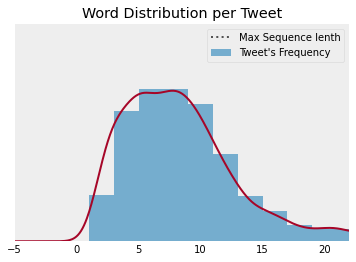

In [19]:
#Plot 
fig, ax = plt.subplots(figsize=(6,4))

data_train['doc_len'].plot(kind='hist',
                      density=True,
                      alpha=0.65,
                      bins=15,
                      label="Tweet's Frequency")

data_train['doc_len'].plot(kind='kde', label='')

ax.set_xlim(-5, 22)
ax.set_xlabel("")
ax.set_ylim(0, 0.13)
ax.set_yticks([])
ax.set_ylabel("")
ax.set_title("Word Distribution per Tweet")
ax.grid(False)
ax.axvline(x=max_seq_len, alpha=0.65, color='k', linestyle=':', label='Max Sequence lenth')
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

plt.legend()
plt.show()

**Tokenize and Pad sequences**

In [20]:
raw_docs_train = data_train['tweets'].tolist()
raw_docs_test  = data_test['tweets'].tolist()

In [21]:
#Training Vocab
# MAX_NB_WORDS = 100000 
#Tokenizing input data
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB),
                      lower=True,
                      char_level=False)
tokenizer.fit_on_texts(raw_docs_train)
word_seq_train = tokenizer.texts_to_sequences(raw_docs_train)
word_seq_test  = tokenizer.texts_to_sequences(raw_docs_test)

word_index = tokenizer.word_index
print('Dictionary Size: ', len(word_index))

Dictionary Size:  3813


In [22]:
#Pad sequences to make all document the same length
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen = max_seq_len)
word_seq_test  = sequence.pad_sequences(word_seq_test, maxlen = max_seq_len)

In [23]:
len(word_seq_train)

3000

**Train Embeddings Weights**

In [24]:
#dimension
EMBEDDING_DIM = 300

In [25]:
# words_not_found = []

# embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
# for word,index in word_index.items():
#     embedding_weights[index,:] = word2vec[word] if word in word2vec else words_not_found.append(word)

# print("Vektor dengan Dimensi : ",embedding_weights.shape)

# print("Sample Words Not Found  ", len(words_not_found))

In [26]:
# words_not_found

In [27]:
train_embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(3814, 300)


In [28]:
# train_embedding_weights[2]

# Hyperparameter CNN 

In [29]:
lr = 0.01
batch_size  = 256
num_epochs  = 20
num_filters = 128
filter_size = 2

In [30]:
# nb_words = min(len(TRAINING_VOCAB), len(word_index))
# nb_words
nb_words = len(word_index)
nb_words

3813

In [31]:
label_names = ['positive', 'neutral','negative']
num_classes = len(label_names)

In [32]:
#train labels

target = []

for i in data_train['label']:
  if i == -1:
    target.append(0)
  elif i == 0:
    target.append(1)
  elif i == 1:
    target.append(2)

data_train['new_label'] = target

train_labels = to_categorical(data_train['new_label'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [33]:
#early stopping for avoid overfitting model
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.01,
                               patience=3,
                               verbose=1)

callbacks_list = [early_stopping]

# Building Model CNN

In [34]:
model = Sequential(name='model')

model.add(Embedding(nb_words+1, EMBEDDING_DIM,
                    weights=[train_embedding_weights],
                    input_length=max_seq_len,
                    trainable=False))

model.add(Conv1D(num_filters, filter_size, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))


model.add(Conv1D(num_filters, filter_size, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(GlobalMaxPooling1D())


model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dense(num_classes, activation='softmax'))


adam = tf.optimizers.Adam(lr)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 300)           1144200   
                                                                 
 conv1d (Conv1D)             (None, 32, 128)           76928     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 128)           32896     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 8, 128)           0         
 1D)                                                         

In [35]:
hist = model.fit(word_seq_train,
                 train_labels,
                 batch_size = batch_size,
                 epochs = num_epochs,
                 validation_split=0.2,
                 callbacks = callbacks_list,
                 shuffle=True,
                 verbose=2)

Epoch 1/20
10/10 - 3s - loss: 1.1071 - accuracy: 0.4008 - val_loss: 1.0266 - val_accuracy: 0.5817 - 3s/epoch - 257ms/step
Epoch 2/20
10/10 - 1s - loss: 0.9670 - accuracy: 0.5579 - val_loss: 0.9102 - val_accuracy: 0.6800 - 1s/epoch - 113ms/step
Epoch 3/20
10/10 - 1s - loss: 0.7806 - accuracy: 0.7100 - val_loss: 0.6660 - val_accuracy: 0.8383 - 1s/epoch - 109ms/step
Epoch 4/20
10/10 - 1s - loss: 0.5279 - accuracy: 0.8117 - val_loss: 0.4304 - val_accuracy: 0.8683 - 1s/epoch - 110ms/step
Epoch 5/20
10/10 - 1s - loss: 0.3650 - accuracy: 0.8658 - val_loss: 0.2966 - val_accuracy: 0.9183 - 1s/epoch - 109ms/step
Epoch 6/20
10/10 - 1s - loss: 0.2961 - accuracy: 0.8950 - val_loss: 0.2424 - val_accuracy: 0.9183 - 1s/epoch - 111ms/step
Epoch 7/20
10/10 - 1s - loss: 0.2528 - accuracy: 0.9208 - val_loss: 0.2092 - val_accuracy: 0.9383 - 1s/epoch - 106ms/step
Epoch 8/20
10/10 - 1s - loss: 0.2121 - accuracy: 0.9304 - val_loss: 0.1903 - val_accuracy: 0.9467 - 1s/epoch - 112ms/step
Epoch 9/20
10/10 - 1s - 

# Evaluation

In [36]:
target_test = []

for i in data_test['label']:
  if i == -1:
    target_test.append(0)
  elif i == 0:
    target_test.append(1)
  elif i == 1:
    target_test.append(2)

data_test['new_label'] = target_test

test_labels = to_categorical(data_test['new_label'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [37]:
y_test = data_test['new_label']

y_pred = model.predict(word_seq_test).round()
pred_df = pd.DataFrame(data=y_pred)
y_pred = pred_df.values.argmax(1)

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       270
           1       0.93      0.92      0.92       248
           2       0.95      0.91      0.93       232

    accuracy                           0.93       750
   macro avg       0.93      0.93      0.93       750
weighted avg       0.93      0.93      0.93       750



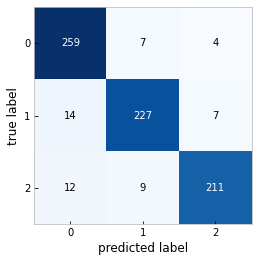

In [39]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
plt.show()

## Upload Predicted Files to Google Drive

In [45]:
predict = pd.DataFrame(columns=['tweets'] + ['label'] + ['predict'])
predict['tweets'] = data_test['tweets']
predict['label'] = y_test
predict['predict'] = y_pred
predict.head()

,tweets,label,predict
2148,need first second dose covid vaccine visit wee...,1,1
1044,motherfucker talk necessary research vaccine b...,0,0
3318,vaccine youre safe severe covid choose get tha...,2,2
439,lot negativity sputnikv circulate social mediu...,0,2
3515,prove power peole care passion love thanks,2,2


In [46]:
predict.to_excel('new_predict.xlsx')
!cp new_predict.xlsx '/content/drive/MyDrive/Colab Notebooks/ARTEFAK SIDANG/model'

print("Uploaded Predict Files to Google Drive")

Uploaded Predict Files to Google Drive


# Loss and Accuracy Visualization

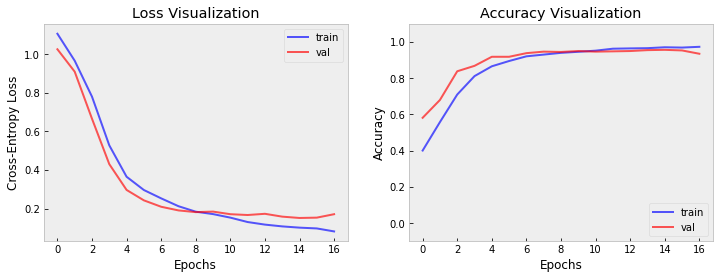

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(hist.history['loss'], lw=2.0, color='b', alpha=0.65, label='train')
ax1.plot(hist.history['val_loss'], lw=2.0, color='r', alpha=0.65, label='val')
ax1.set_title('Loss Visualization')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.legend(loc='upper right')
ax2.plot(hist.history['accuracy'], lw=2.0, color='b', alpha=0.65, label='train')
ax2.plot(hist.history['val_accuracy'], lw=2.0, color='r', alpha=0.65, label='val')
ax2.set_title('Accuracy Visualization')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')

ax1.grid(False)
ax2.grid(False)

ax2.set_ylim(-0.1, 1.1)
plt.show()


# Save Model

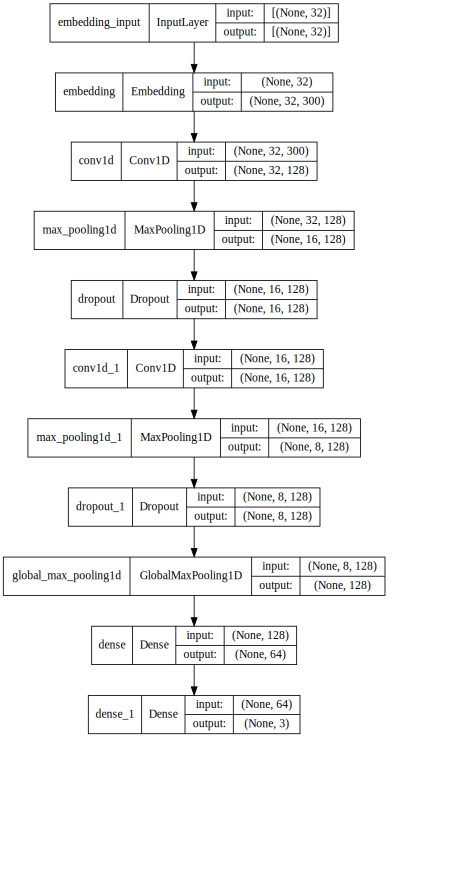

In [41]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes = True, dpi=60).create(prog='dot', format='svg'))

In [42]:
model.save("model_cnn.h5")
print("Saved model to disk")

Saved model to disk


In [43]:
with open('new_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Saved tokenizer model to disk")

Saved tokenizer model to disk


In [44]:
!cp model_cnn.h5 '/content/drive/MyDrive/Colab Notebooks/ARTEFAK SIDANG/model'
!cp new_tokenizer.pickle '/content/drive/MyDrive/Colab Notebooks/ARTEFAK SIDANG/model'

print("Uploaded model to Google Drive")

Uploaded model to Google Drive
